In [1]:
# Load one million book reviews.
import pandas as pd
df = pd.read_csv('c:/Users/Owen/books_small.csv')

In [2]:
# Drop missing reviews.
df = df.dropna(subset=['reviewText'])
df.shape

(999940, 10)

In [3]:
# 'reviewText' contains book review text. 'overall' shows the number of stars the reviewer rated the book.
df.head(1)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,5111046,A38UEYF5AFDU4I,1416583475,"Jason Joyner ""On the journey""","[0, 0]","Overview: What would a Mexican housekeeper, a ...",5.0,Fiction with Themes that Matter,1272326400,"04 27, 2010"


In [4]:
# Print majority class baseline.
from sklearn.metrics import accuracy_score
majority_class = df.overall.mode()[0]
guesses_majority = [majority_class] * len(df.overall)
print(f'Majority Class Baseline: {(accuracy_score(df.overall, guesses_majority)) * 100:.2f}%.')

Majority Class Baseline: 55.90%.


In [ ]:
# Basic exploration of the review lengths.
import numpy as np
df['review_lengths'] = list(map(len, df.reviewText.str.split(' ')))
df['review_lengths'].describe()

In [4]:
import string
import spacy
from spacy.lang.en import English
# Create punctuation list.
punctuations = string.punctuation

# Create stopwords list.
# nlp = spacy.load('en_core_web_lg')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load tokenizer, tagger, parser, NER, and word vectors.
parser = English()

# Create tokenizer function.
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    
    # For each token, lemmatize and change to lowercase.
    mytokens = [word.lemma_.lower().strip() if word.lemma_ != '-PRON-'
                else word.lower_ for word in mytokens]
    # Remove stop words.
    mytokens = [word for word in mytokens if word not in stop_words
                and word not in punctuations]
    # Return preprocessed list of tokens.
    return mytokens

In [5]:
# Make a copy of original df so you don't have to reload the original every new experiment.
copy = df.copy()
copy.shape

(999940, 10)

In [6]:

copy.head(1)

,Unnamed: 0,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,5111046,A38UEYF5AFDU4I,1416583475,"Jason Joyner ""On the journey""","[0, 0]","Overview: What would a Mexican housekeeper, a ...",5.0,Fiction with Themes that Matter,1272326400,"04 27, 2010"


In [7]:
feature = 'reviewText'
target = 'overall'

In [8]:
copy = copy[['reviewText', 'overall']]

In [9]:
copy.head()

,reviewText,overall
0,"Overview: What would a Mexican housekeeper, a ...",5.0
1,I began reading as soon as I downloaded and di...,4.0
2,The Mix & Match Guide to Companion Planting is...,5.0
3,It isn't often I have an opportunity to read a...,4.0
4,"I love this book. Very interesting story, char...",5.0


In [95]:
# Create a smaller sample to work with so things run faster.
small_copy = copy.sample(1000, random_state=0)

# Split the dataframe into positive and negative reviews.
positive = small_copy[(small_copy.overall == 5.0) | (small_copy.overall == 4.0)]
negative = small_copy[(small_copy.overall == 2.0) | (small_copy.overall == 1.0)]

In [109]:
# Build document term matrix to use for LDA topic modeling.
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(tokenizer = spacy_tokenizer,
                                 ngram_range = (1,1),
                                 max_df = 0.8,
                                 min_df = 2)

dtm_p = bow_vectorizer.fit_transform(positive.reviewText)
dtm_feature_names_p = bow_vectorizer.get_feature_names()

dtm_n = bow_vectorizer.fit_transform(negative.reviewText)
dtm_feature_names_n = bow_vectorizer.get_feature_names()

print(f'Positive reviews document term matrix shape: {dtm_p.shape}')
print(f'Negative reviews document term matrix shape: {dtm_n.shape}')

Positive reviews document term matrix shape: (806, 4773)
Negative reviews document term matrix shape: (89, 740)


In [110]:
# Convert document term matrices to pandas dataframes.
term_df_p = pd.DataFrame(dtm_p.toarray(), columns=dtm_feature_names_p)
term_df_n = pd.DataFrame(dtm_n.toarray(), columns=dtm_feature_names_n)

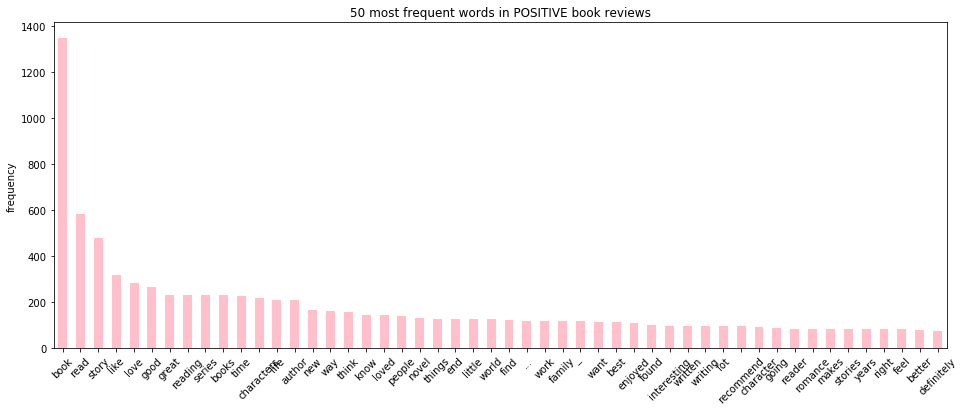

In [111]:
# Look at the top 50 words from POSITIVE book reviews.
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
term_df_p.sum(axis=0).sort_values(ascending=False)[0:50].plot.bar(color='pink')
plt.title('50 most frequent words in POSITIVE book reviews')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.show()

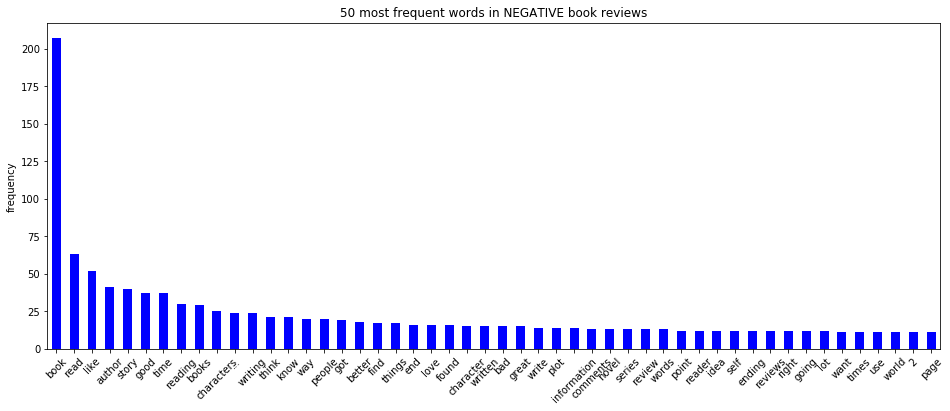

In [112]:
# Look at the top 50 words from NEGATIVE book reviews.
import matplotlib.pyplot as plt
plt.figure(figsize=(16,6))
term_df_n.sum(axis=0).sort_values(ascending=False)[0:50].plot.bar(color='blue')
plt.title('50 most frequent words in NEGATIVE book reviews')
plt.ylabel('frequency')
plt.xticks(rotation=45)
plt.show()

In [124]:
# Build the topic model.
from sklearn.decomposition import LatentDirichletAllocation
bow_vectorizer = CountVectorizer(tokenizer = spacy_tokenizer,
                                 ngram_range = (1,1),
                                 max_df = 0.5,
                                 min_df = 2)

dtm = bow_vectorizer.fit_transform(small_copy.reviewText)
dtm_feature_names = bow_vectorizer.get_feature_names()

topics = 10
lda = LatentDirichletAllocation(n_components=topics, random_state=0)
lda.fit(dtm)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [125]:
# View the topics.
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm, bow_vectorizer)

C:\Users\Owen\Anaconda3\envs\unit2\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning:

Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.




PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.056578  0.005412       1        1  17.643999
7     -0.044277 -0.000824       2        1  16.525741
1     -0.074129 -0.012194       3        1  15.777827
3     -0.028487  0.018632       4        1  11.088548
6     -0.024478 -0.039315       5        1  10.529875
9     -0.018203 -0.009681       6        1   9.408127
5      0.111594 -0.142820       7        1   6.647984
4     -0.054127  0.061955       8        1   4.860087
0      0.032699  0.003955       9        1   3.904149
8      0.155987  0.114881      10        1   3.613664, topic_info=     Category        Freq     Term       Total  loglift  logprob
4121  Default  639.000000     read  639.000000  30.0000  30.0000
3098  Default  292.000000     love  292.000000  29.0000  29.0000
4896  Default  541.000000    story  541.000000  28.0000  28.0000
2895  Default   39.000000   kindle   39.000000  27.0000  27.0000
450   Default  266.000000   author  266.000000  26.0000  26.0000
...       ...         ...      ...         ...      ...      ...
3929  Topic10    5.443821   pretty   58.888594   0.9393  -5.9059
5209  Topic10    5.969650     time  267.330679  -0.4814  -5.8137
4127  Topic10    5.951774  reading  266.283603  -0.4804  -5.8167
5684  Topic10    5.634068  written  117.676442   0.2813  -5.8715
2114  Topic10    5.544793    found  123.408130   0.2178  -5.8875

[794 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4         1  0.312082       --
4         2  0.112029       --
4         3  0.016004       --
4         4  0.168044       --
4         5  0.040010       --
...     ...       ...      ...
5701      9  0.013429    young
5707      3  0.809895  zealand
5711      1  0.837483  zombies
5711      5  0.059820  zombies
5711      8  0.059820  zombies

[2067 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 8, 2, 4, 7, 10, 6, 5, 1, 9])

In [47]:
from sklearn.model_selection import train_test_split
# Create features matrix and target vector.
X = copy[feature]
y = copy[target]

# Randomly split data into stratified train (80%) and test (20%).
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=0)

In [53]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vec = TfidfVectorizer(tokenizer = spacy_tokenizer,
                                 ngram_range = (1,1),
                                 max_df = 0.5,
                                 min_df = 2)

X_train_vecs = tfidf_vec.fit_transform(X_train)
X_test_vecs = tfidf_vec.transform(X_test)

Wall time: 45min 29s


In [54]:
%%time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
# Instantiate the classifier with mostly default hyperparameters.
classifier = LogisticRegression(solver='lbfgs', multi_class='auto', n_jobs=-1,
                                random_state=42)

# Create pipeline to clean, get bag-of-words review vectors, then run logistic
# regression.
pipe = make_pipeline(classifier)

# Fit the model on train.
pipe.fit(X_train_vecs, y_train)

Wall time: 1min 52s


Pipeline(memory=None,
         steps=[('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=-1, penalty='l2',
                                    random_state=42, solver='lbfgs', tol=0.0001,
                                    verbose=0, warm_start=False))],
         verbose=False)

In [55]:
from sklearn.metrics import accuracy_score
# Create predictions vector from test features.
y_pred = pipe.predict(X_test_vecs)

# Find model accuracy.
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))

Logistic Regression Accuracy: 0.6389933396003761


In [59]:
%%time
from lightgbm import LGBMClassifier
classifier = LGBMClassifier(objective='multiclass', num_class=5, 
                            metric='multi_error', num_jobs=-1, seed=0)

pipe = make_pipeline(classifier)
pipe.fit(X_train_vecs, y_train)

Wall time: 9min 36s


Pipeline(memory=None,
         steps=[('lgbmclassifier',
                 LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                colsample_bytree=1.0, importance_type='split',
                                learning_rate=0.1, max_depth=-1,
                                metric='multi_error', min_child_samples=20,
                                min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=100, n_jobs=-1, num_class=5,
                                num_jobs=-1, num_leaves=31,
                                objective='multiclass', random_state=None,
                                reg_alpha=0.0, reg_lambda=0.0, seed=0,
                                silent=True, subsample=1.0,
                                subsample_for_bin=200000, subsample_freq=0))],
         verbose=False)

In [60]:
y_pred = pipe.predict(X_test_vecs)

print("LGBMClassifier Accuracy:", accuracy_score(y_test, y_pred))

LGBMClassifier Accuracy: 0.6228773726423585


In [64]:
%%time
eval_set = [(X_test_vecs, y_test)]

lgbm = LGBMClassifier(objective='multiclass', num_class=5, 
                            n_estimators=1000, num_jobs=-1, seed=0)

lgbm.fit(X_train_vecs, y_train, eval_set=eval_set, 
          eval_metric='multi_error', early_stopping_rounds=50)

[1]	valid_0's multi_error: 0.440981	valid_0's multi_logloss: 1.15818
Training until validation scores don't improve for 50 rounds
[2]	valid_0's multi_error: 0.440981	valid_0's multi_logloss: 1.14437
[3]	valid_0's multi_error: 0.440981	valid_0's multi_logloss: 1.13282
[4]	valid_0's multi_error: 0.440981	valid_0's multi_logloss: 1.12269
[5]	valid_0's multi_error: 0.440966	valid_0's multi_logloss: 1.1137
[6]	valid_0's multi_error: 0.440811	valid_0's multi_logloss: 1.10525
[7]	valid_0's multi_error: 0.440246	valid_0's multi_logloss: 1.09776
[8]	valid_0's multi_error: 0.439526	valid_0's multi_logloss: 1.09079
[9]	valid_0's multi_error: 0.438441	valid_0's multi_logloss: 1.0844
[10]	valid_0's multi_error: 0.437211	valid_0's multi_logloss: 1.0785
[11]	valid_0's multi_error: 0.434326	valid_0's multi_logloss: 1.07336
[12]	valid_0's multi_error: 0.432216	valid_0's multi_logloss: 1.06833
[13]	valid_0's multi_error: 0.430231	valid_0's multi_logloss: 1.06366
[14]	valid_0's multi_error: 0.428206	vali

[229]	valid_0's multi_error: 0.363262	valid_0's multi_logloss: 0.885983
[230]	valid_0's multi_error: 0.363197	valid_0's multi_logloss: 0.885787
[231]	valid_0's multi_error: 0.363182	valid_0's multi_logloss: 0.885601
[232]	valid_0's multi_error: 0.363087	valid_0's multi_logloss: 0.885407
[233]	valid_0's multi_error: 0.363017	valid_0's multi_logloss: 0.885238
[234]	valid_0's multi_error: 0.362952	valid_0's multi_logloss: 0.885058
[235]	valid_0's multi_error: 0.362902	valid_0's multi_logloss: 0.884861
[236]	valid_0's multi_error: 0.362757	valid_0's multi_logloss: 0.884681
[237]	valid_0's multi_error: 0.362757	valid_0's multi_logloss: 0.884497
[238]	valid_0's multi_error: 0.362767	valid_0's multi_logloss: 0.884315
[239]	valid_0's multi_error: 0.362652	valid_0's multi_logloss: 0.884142
[240]	valid_0's multi_error: 0.362612	valid_0's multi_logloss: 0.883956
[241]	valid_0's multi_error: 0.362582	valid_0's multi_logloss: 0.883766
[242]	valid_0's multi_error: 0.362557	valid_0's multi_logloss: 0

[455]	valid_0's multi_error: 0.356421	valid_0's multi_logloss: 0.863637
[456]	valid_0's multi_error: 0.356551	valid_0's multi_logloss: 0.86359
[457]	valid_0's multi_error: 0.356511	valid_0's multi_logloss: 0.863536
[458]	valid_0's multi_error: 0.356431	valid_0's multi_logloss: 0.863482
[459]	valid_0's multi_error: 0.356396	valid_0's multi_logloss: 0.863423
[460]	valid_0's multi_error: 0.356336	valid_0's multi_logloss: 0.863366
[461]	valid_0's multi_error: 0.356336	valid_0's multi_logloss: 0.863325
[462]	valid_0's multi_error: 0.356361	valid_0's multi_logloss: 0.863271
[463]	valid_0's multi_error: 0.356296	valid_0's multi_logloss: 0.863237
[464]	valid_0's multi_error: 0.356241	valid_0's multi_logloss: 0.863191
[465]	valid_0's multi_error: 0.356291	valid_0's multi_logloss: 0.863137
[466]	valid_0's multi_error: 0.356311	valid_0's multi_logloss: 0.86309
[467]	valid_0's multi_error: 0.356306	valid_0's multi_logloss: 0.863044
[468]	valid_0's multi_error: 0.356261	valid_0's multi_logloss: 0.8

[682]	valid_0's multi_error: 0.353971	valid_0's multi_logloss: 0.855901
[683]	valid_0's multi_error: 0.353976	valid_0's multi_logloss: 0.855876
[684]	valid_0's multi_error: 0.353981	valid_0's multi_logloss: 0.85586
[685]	valid_0's multi_error: 0.353971	valid_0's multi_logloss: 0.855832
[686]	valid_0's multi_error: 0.353931	valid_0's multi_logloss: 0.855812
[687]	valid_0's multi_error: 0.353911	valid_0's multi_logloss: 0.855797
[688]	valid_0's multi_error: 0.353876	valid_0's multi_logloss: 0.855778
[689]	valid_0's multi_error: 0.353911	valid_0's multi_logloss: 0.855761
[690]	valid_0's multi_error: 0.353851	valid_0's multi_logloss: 0.855743
[691]	valid_0's multi_error: 0.353836	valid_0's multi_logloss: 0.855712
[692]	valid_0's multi_error: 0.353791	valid_0's multi_logloss: 0.855687
[693]	valid_0's multi_error: 0.353766	valid_0's multi_logloss: 0.855664
[694]	valid_0's multi_error: 0.353791	valid_0's multi_logloss: 0.855655
[695]	valid_0's multi_error: 0.353816	valid_0's multi_logloss: 0.

[908]	valid_0's multi_error: 0.352981	valid_0's multi_logloss: 0.85219
[909]	valid_0's multi_error: 0.352936	valid_0's multi_logloss: 0.852181
[910]	valid_0's multi_error: 0.352946	valid_0's multi_logloss: 0.852178
[911]	valid_0's multi_error: 0.352886	valid_0's multi_logloss: 0.852179
[912]	valid_0's multi_error: 0.352761	valid_0's multi_logloss: 0.852163
[913]	valid_0's multi_error: 0.352711	valid_0's multi_logloss: 0.852157
[914]	valid_0's multi_error: 0.352701	valid_0's multi_logloss: 0.852141
[915]	valid_0's multi_error: 0.352731	valid_0's multi_logloss: 0.852134
[916]	valid_0's multi_error: 0.352716	valid_0's multi_logloss: 0.852124
[917]	valid_0's multi_error: 0.352696	valid_0's multi_logloss: 0.852113
[918]	valid_0's multi_error: 0.352746	valid_0's multi_logloss: 0.852097
[919]	valid_0's multi_error: 0.352736	valid_0's multi_logloss: 0.852077
[920]	valid_0's multi_error: 0.352751	valid_0's multi_logloss: 0.852064
[921]	valid_0's multi_error: 0.352716	valid_0's multi_logloss: 0.

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=1000, n_jobs=-1, num_class=5, num_jobs=-1,
               num_leaves=31, objective='multiclass', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, seed=0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [68]:
y_pred = lgbm.predict(X_test_vecs)

print("LGBMClassifier Accuracy:", accuracy_score(y_test, y_pred))

LGBMClassifier Accuracy: 0.6473938436306178


In [73]:
X_train_vecs.shape, X_test_vecs.shape

((799952, 296653), (199988, 296653))

In [99]:
small_copy = copy.sample(100000, random_state=0)

In [100]:
small_copy = small_copy.replace({5.0:1.0, 4.0:1.0, 3.0:0.0, 2.0:0.0, 1.0:0.0})

In [101]:
small_copy.overall.value_counts(normalize=True)

1.0    0.80916
0.0    0.19084
Name: overall, dtype: float64

In [102]:
X = small_copy[feature]
y = small_copy[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    stratify=y, random_state=0)

In [103]:
%%time
tfidf_vec = TfidfVectorizer(tokenizer = spacy_tokenizer,
                                 ngram_range = (1,1),
                                 max_df = 0.5,
                                 min_df = 2)

X_train_vecs = tfidf_vec.fit_transform(X_train)
X_test_vecs = tfidf_vec.transform(X_test)

Wall time: 2min


In [106]:
%%time
eval_set = [(X_test_vecs, y_test)]

lgbm = LGBMClassifier(objective='binary', is_unbalance=True, 
                            n_estimators=5000, num_jobs=-1, seed=0)

lgbm.fit(X_train_vecs, y_train, eval_set=eval_set, 
          eval_metric='binary', early_stopping_rounds=100)

[1]	valid_0's binary_logloss: 0.474411
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.469542
[3]	valid_0's binary_logloss: 0.46975
[4]	valid_0's binary_logloss: 0.472653
[5]	valid_0's binary_logloss: 0.475283
[6]	valid_0's binary_logloss: 0.480005
[7]	valid_0's binary_logloss: 0.484683
[8]	valid_0's binary_logloss: 0.488671
[9]	valid_0's binary_logloss: 0.49327
[10]	valid_0's binary_logloss: 0.496881
[11]	valid_0's binary_logloss: 0.500114
[12]	valid_0's binary_logloss: 0.503946
[13]	valid_0's binary_logloss: 0.506085
[14]	valid_0's binary_logloss: 0.508725
[15]	valid_0's binary_logloss: 0.510179
[16]	valid_0's binary_logloss: 0.5128
[17]	valid_0's binary_logloss: 0.513721
[18]	valid_0's binary_logloss: 0.514989
[19]	valid_0's binary_logloss: 0.515395
[20]	valid_0's binary_logloss: 0.515801
[21]	valid_0's binary_logloss: 0.515766
[22]	valid_0's binary_logloss: 0.515781
[23]	valid_0's binary_logloss: 0.516533
[24]	valid_0's binary_logloss: 

[402]	valid_0's binary_logloss: 0.388828
[403]	valid_0's binary_logloss: 0.388753
[404]	valid_0's binary_logloss: 0.388574
[405]	valid_0's binary_logloss: 0.388482
[406]	valid_0's binary_logloss: 0.388355
[407]	valid_0's binary_logloss: 0.388339
[408]	valid_0's binary_logloss: 0.388225
[409]	valid_0's binary_logloss: 0.388154
[410]	valid_0's binary_logloss: 0.388117
[411]	valid_0's binary_logloss: 0.388093
[412]	valid_0's binary_logloss: 0.388017
[413]	valid_0's binary_logloss: 0.387973
[414]	valid_0's binary_logloss: 0.387883
[415]	valid_0's binary_logloss: 0.387701
[416]	valid_0's binary_logloss: 0.387635
[417]	valid_0's binary_logloss: 0.387562
[418]	valid_0's binary_logloss: 0.387534
[419]	valid_0's binary_logloss: 0.387408
[420]	valid_0's binary_logloss: 0.387298
[421]	valid_0's binary_logloss: 0.387282
[422]	valid_0's binary_logloss: 0.38713
[423]	valid_0's binary_logloss: 0.387048
[424]	valid_0's binary_logloss: 0.386998
[425]	valid_0's binary_logloss: 0.386911
[426]	valid_0's b

[802]	valid_0's binary_logloss: 0.364017
[803]	valid_0's binary_logloss: 0.363976
[804]	valid_0's binary_logloss: 0.364014
[805]	valid_0's binary_logloss: 0.364004
[806]	valid_0's binary_logloss: 0.364001
[807]	valid_0's binary_logloss: 0.363985
[808]	valid_0's binary_logloss: 0.363965
[809]	valid_0's binary_logloss: 0.36395
[810]	valid_0's binary_logloss: 0.36391
[811]	valid_0's binary_logloss: 0.363856
[812]	valid_0's binary_logloss: 0.363843
[813]	valid_0's binary_logloss: 0.363834
[814]	valid_0's binary_logloss: 0.363826
[815]	valid_0's binary_logloss: 0.363733
[816]	valid_0's binary_logloss: 0.363682
[817]	valid_0's binary_logloss: 0.363621
[818]	valid_0's binary_logloss: 0.363603
[819]	valid_0's binary_logloss: 0.363554
[820]	valid_0's binary_logloss: 0.363488
[821]	valid_0's binary_logloss: 0.363454
[822]	valid_0's binary_logloss: 0.363409
[823]	valid_0's binary_logloss: 0.363401
[824]	valid_0's binary_logloss: 0.363331
[825]	valid_0's binary_logloss: 0.363282
[826]	valid_0's bi

[1197]	valid_0's binary_logloss: 0.353896
[1198]	valid_0's binary_logloss: 0.353901
[1199]	valid_0's binary_logloss: 0.353871
[1200]	valid_0's binary_logloss: 0.353879
[1201]	valid_0's binary_logloss: 0.353865
[1202]	valid_0's binary_logloss: 0.353861
[1203]	valid_0's binary_logloss: 0.353917
[1204]	valid_0's binary_logloss: 0.353892
[1205]	valid_0's binary_logloss: 0.35383
[1206]	valid_0's binary_logloss: 0.353799
[1207]	valid_0's binary_logloss: 0.353723
[1208]	valid_0's binary_logloss: 0.353728
[1209]	valid_0's binary_logloss: 0.353735
[1210]	valid_0's binary_logloss: 0.353714
[1211]	valid_0's binary_logloss: 0.353725
[1212]	valid_0's binary_logloss: 0.353677
[1213]	valid_0's binary_logloss: 0.353686
[1214]	valid_0's binary_logloss: 0.353684
[1215]	valid_0's binary_logloss: 0.353672
[1216]	valid_0's binary_logloss: 0.353708
[1217]	valid_0's binary_logloss: 0.353704
[1218]	valid_0's binary_logloss: 0.353688
[1219]	valid_0's binary_logloss: 0.353659
[1220]	valid_0's binary_logloss: 0.

[1587]	valid_0's binary_logloss: 0.35064
[1588]	valid_0's binary_logloss: 0.350617
[1589]	valid_0's binary_logloss: 0.350666
[1590]	valid_0's binary_logloss: 0.350715
[1591]	valid_0's binary_logloss: 0.350726
[1592]	valid_0's binary_logloss: 0.350756
[1593]	valid_0's binary_logloss: 0.350757
[1594]	valid_0's binary_logloss: 0.350766
[1595]	valid_0's binary_logloss: 0.350795
[1596]	valid_0's binary_logloss: 0.350759
[1597]	valid_0's binary_logloss: 0.350734
[1598]	valid_0's binary_logloss: 0.350766
[1599]	valid_0's binary_logloss: 0.350771
[1600]	valid_0's binary_logloss: 0.35078
[1601]	valid_0's binary_logloss: 0.350743
[1602]	valid_0's binary_logloss: 0.350719
[1603]	valid_0's binary_logloss: 0.350777
[1604]	valid_0's binary_logloss: 0.350797
[1605]	valid_0's binary_logloss: 0.350847
[1606]	valid_0's binary_logloss: 0.350867
[1607]	valid_0's binary_logloss: 0.350876
[1608]	valid_0's binary_logloss: 0.3509
[1609]	valid_0's binary_logloss: 0.350917
[1610]	valid_0's binary_logloss: 0.350

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', is_unbalance=True, learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=5000, n_jobs=-1, num_jobs=-1,
               num_leaves=31, objective='binary', random_state=None,
               reg_alpha=0.0, reg_lambda=0.0, seed=0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [107]:
y_pred = lgbm.predict(X_test_vecs)

print("LGBMClassifier Accuracy:", accuracy_score(y_test, y_pred))

LGBMClassifier Accuracy: 0.85105


In [3]:
# nlp = spacy.load('en_core_web_lg')

In [ ]:
# nlp(df['reviewText'])